# Chrip Pulse Simulation and Processing

In [31]:
# Imports

using PyPlot
using FFTW

## 1. Chirp Pulse Creation

**Creating the chirp**

In [28]:
c = 343; # Speed of sound in air in m/s
fs = 44100; # This is the sample rate of the sonar.
dt = 1/fs; # This is the sample spacing
r_max = 10; # Maximum range in metres to which to simulate.
t_max = 2*r_max/c; # Time delay to max range

# Create an array containing the time values of the samples
t = collect(0:dt:t_max); # t=0:dt:t_max defines a "range".
r = c*t/2;

# NOW create the chirp pulse, shifted by an amount td, to start at
# some time td-T/2>0. 
f0 = 10000; # Centre frequency is 10 kHz
B = 4000; # Chirp bandwidth
T = 5E-3; # Chirp pulse length
K = B/T; # Chirp rate

# Define a simple a rect() function which returns for -0.5<=t<=0.5 or 0.
# The function will work if t is an array of values.
rect(t) = (abs.(t) .<= 0.5)*1.0

# rect(t/T) spans the interval [-T/2,T/2]
# We must therefore delay the chirp pulse so that it starts after t=0.
# Shift the chirp pulse by 0.6T units to the right, so that it starts at 0.1*T

td = 0.50*T; # Chirp delay
v_tx = cos.( 2*pi*(f0*(t .- td) + 0.5*K*(t .- td).^2) ) .* rect.((t .-td)/T);

**Chrip in the time domain**

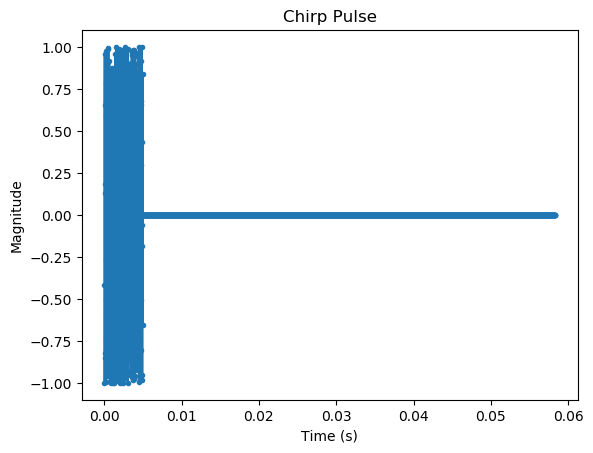

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f882e4cfba8>

In [46]:
figure()
title("Chirp Pulse")
xlabel("Time (s)")
ylabel("Magnitude")
plot(t,v_tx,".-")

**Chirp in the frequency domain**

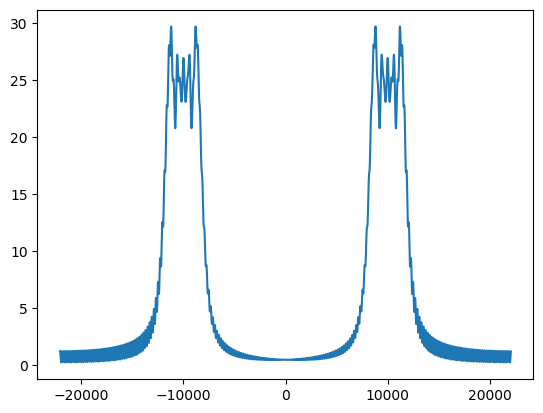

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f882e5f5240>

In [42]:
#Label the frequency axis in Hz
N = length(t);
Δf = 1/(N*dt) # spacing in frequency domain

#create array of freq values stored in f_axis. First element maps to 0Hz
if mod(N,2)==0 # case N even
    f_axis = (-N/2:N/2-1)*Δf;
else # case N odd
    f_axis = (-(N-1)/2 : (N-1)/2)*Δf;
end

V_TX = fft(v_tx)
plot(f_axis,fftshift(abs.(V_TX)),"-")